# Named Entity Recognition


### importing packages and libraries

In [2]:
# Install extra-dependencies
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

In [3]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn_crfsuite.metrics import flat_classification_report
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from ipywidgets import interact_manual
from ipywidgets import widgets
from nltk.tokenize import RegexpTokenizer
import re
import string

Using TensorFlow backend.


## Training Parameters


In [4]:
# Hyperparams for CPU training
BATCH_SIZE = 32
EPOCHS = 7
MAX_LEN = 75
EMBEDDING = 20

# # Hyperparams for GPU training
# BATCH_SIZE = 512  # Number of samples used at each iteration
# EPOCHS = 7 
# MAX_LEN = 75 
# EMBEDDING = 40  # Size of dimension of word embedding vector

## Dataset

In [5]:
data = pd.read_csv("/content/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill") #to fill Null/Nan values

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
num_words = len(words)
tags = list(set(data["Tag"].values))
num_tags = len(tags)


print("Number of words in the dataset: ", num_words)
print("Tags:", tags)
print("Number of Labels: ", num_tags)
print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10) 

('Number of sentences: ', 47959)
('Number of words in the dataset: ', 35176)
('Tags:', [u'I-art', u'B-gpe', u'B-art', u'I-per', u'I-tim', u'B-org', u'O', u'B-geo', u'B-tim', u'I-geo', u'B-per', u'I-eve', u'B-eve', u'I-gpe', u'I-org', u'I-nat', u'B-nat'])
('Number of Labels: ', 17)
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [6]:
class Get_Sentence(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_sent(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = Get_Sentence(data)
sent = getter.get_sent()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[(u'Thousands', u'NNS', u'O'), (u'of', u'IN', u'O'), (u'demonstrators', u'NNS', u'O'), (u'have', u'VBP', u'O'), (u'marched', u'VBN', u'O'), (u'through', u'IN', u'O'), (u'London', u'NNP', u'B-geo'), (u'to', u'TO', u'O'), (u'protest', u'VB', u'O'), (u'the', u'DT', u'O'), (u'war', u'NN', u'O'), (u'in', u'IN', u'O'), (u'Iraq', u'NNP', u'B-geo'), (u'and', u'CC', u'O'), (u'demand', u'VB', u'O'), (u'the', u'DT', u'O'), (u'withdrawal', u'NN', u'O'), (u'of', u'IN', u'O'), (u'British', u'JJ', u'B-gpe'), (u'troops', u'NNS', u'O'), (u'from', u'IN', u'O'), (u'that', u'DT', u'O'), (u'country', u'NN', u'O'), (u'.', u'.', u'O')]


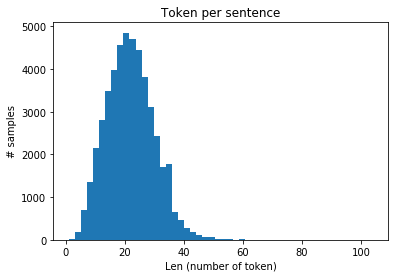

In [7]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## Preprocessing Data


In [8]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}


# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])


# One-Hot encode
y = [to_categorical(i, num_classes=num_tags+1) for i in y]  # n_tags+1(PAD)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train.shape, X_test.shape, np.array(y_train).shape, np.array(y_test).shape


((43163, 75), (4796, 75), (43163, 75, 18), (4796, 75, 18))

## Model


In [9]:

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=num_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN)(input)  
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  
model = TimeDistributed(Dense(50, activation="tanh"))(model)  
crf = CRF(num_tags+1)  # CRF layer, n_tags+1(PAD)
output = crf(model)  # output

model = Model(input, output)
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

/usr/local/lib/python2.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python2.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703560    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 18)            1278      
Total params: 738,288
Trainable params: 738,288
Non-trainable params: 0
_________________________________________________________________


## Training & Evaluation



In [11]:
history = model.fit(X_train, np.array(y_train), batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=0.1, verbose=2)

/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38846 samples, validate on 4317 samples
Epoch 1/7
 - 150s - loss: 0.1766 - crf_viterbi_accuracy: 0.9537 - val_loss: 0.0464 - val_crf_viterbi_accuracy: 0.9857
Epoch 2/7
 - 148s - loss: 0.0307 - crf_viterbi_accuracy: 0.9891 - val_loss: 0.0235 - val_crf_viterbi_accuracy: 0.9895
Epoch 3/7
 - 150s - loss: 0.0121 - crf_viterbi_accuracy: 0.9920 - val_loss: 0.0111 - val_crf_viterbi_accuracy: 0.9902
Epoch 4/7
 - 150s - loss: -2.7892e-03 - crf_viterbi_accuracy: 0.9931 - val_loss: -3.0264e-03 - val_crf_viterbi_accuracy: 0.9906
Epoch 5/7
 - 150s - loss: -1.9216e-02 - crf_viterbi_accuracy: 0.9939 - val_loss: -1.7877e-02 - val_crf_viterbi_accuracy: 0.9902
Epoch 6/7
 - 150s - loss: -3.6608e-02 - crf_viterbi_accuracy: 0.9945 - val_loss: -3.3736e-02 - val_crf_viterbi_accuracy: 0.9903
Epoch 7/7
 - 151s - loss: -5.4247e-02 - crf_viterbi_accuracy: 0.9952 - val_loss: -4.8571e-02 - val_crf_viterbi_accuracy: 0.9901


In [12]:
# Evaluate
pred_cat = model.predict(X_test)
pred = np.argmax(pred_cat, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [13]:
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_test_true_tag = [[idx2tag[i] for i in row] for row in y_test_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_test_true_tag)
print(report)

              precision    recall  f1-score   support

       B-art       0.27      0.08      0.13        36
       B-eve       0.33      0.21      0.26        24
       B-geo       0.87      0.87      0.87      3801
       B-gpe       0.97      0.94      0.95      1664
       B-nat       0.35      0.33      0.34        18
       B-org       0.74      0.73      0.73      1996
       B-per       0.85      0.77      0.81      1657
       B-tim       0.91      0.88      0.89      1999
       I-art       0.31      0.12      0.17        34
       I-eve       0.42      0.40      0.41        20
       I-geo       0.81      0.79      0.80       776
       I-gpe       0.91      0.48      0.62        21
       I-nat       0.50      0.40      0.44         5
       I-org       0.79      0.72      0.76      1694
       I-per       0.87      0.82      0.85      1634
       I-tim       0.79      0.78      0.78       668
           O       0.99      0.99      0.99     89179
         PAD       1.00    

Test some of the samples in the test set. It will test on a different sample at each execution.

In [14]:
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "Actual", "Predicted"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 1426 of 4796 (Test Set)
Word           ||Actual||Predicted
The            : O     O
incoming       : O     O
administration : O     O
of             : O     O
U.S.           : B-geo B-org
President-elect: B-per I-org
Barack         : I-per I-org
Obama          : I-per B-per
is             : O     O
assembling     : O     O
a              : O     O
team           : O     O
of             : O     O
advisors       : O     O
and            : O     O
staffers       : O     O
,              : O     O
most           : O     O
of             : O     O
whom           : O     O
worked         : O     O
for            : O     O
the            : O     O
last           : O     O
Democratic     : O     B-org
administration : O     O
under          : O     O
former         : O     O
President      : B-per B-per
Bill           : I-per I-per
Clinton        : I-per I-per
.              : O     O


## Test model on sample sentences



In [15]:
def tokenize(s) : # Custom Tokenizer

    tokenizer=RegexpTokenizer(r'\w+') 
    return tokenizer.tokenize(s)

def get_prediction(sentence):
    test_sentence = tokenize(sentence) # Tokenization
    # Preprocessing
    x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=word2idx["PAD"], maxlen=MAX_LEN)
    # Evaluation
    p = model.predict(np.array([x_test_sent[0]]))
    p = np.argmax(p, axis=-1)
    # Visualization
    print("{:15}||{}".format("Word", "Prediction"))
    print(30 * "=")
    all=list ()
    for w, pred in zip(test_sentence, p[0]):
        print("{:15}: {:5}".format(w, idx2tag[pred]))
    #     all.append([w,idx2tag[pred]])
    # return all

interact_manual(get_prediction, sentence=widgets.Textarea(placeholder='Type your sentence here'));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KFRleHRhcmVhKHZhbHVlPXUnJywgZGVzY3JpcHRpb249dSdzZW50ZW5jZScsIHBsYWNlaG9sZGVyPXUnVHlwZSB5b3VyIHNlbnRlbmNlIGhlcmUnKSwgQnXigKY=


In [16]:
a=get_prediction("PTCL is the worst organization")
print(a)

Word           ||Prediction
PTCL           : B-org
is             : O    
the            : O    
worst          : O    
organization   : O    
None


## Save the model

In [17]:

# Saving Vocab
with open('models/word_to_index.pickle', 'wb') as f:
    pickle.dump(word2idx, f, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Vocab
with open('models/tag_to_index.pickle', 'wb') as f:
    pickle.dump(tag2idx, f, protocol=pickle.HIGHEST_PROTOCOL)
    
# Saving Model Weight
model.save_weights('models/lstm_crf_weights.h5')